# Predict Options Volatility Movement

### In this notebook, Instead of predicting the next n day's Volailtility based on historical volatility, we will predict the binary variable — predict the movement up or down. 

### We will normalize our n-days window data only by their mean and variance (z-score normalization of Open, High, Low, Close), a multivariate time series. 

### We will use CNN as a classifier for building tensorflow LSTM model.

In [3]:
#initial Imports
import pandas as pd
import numpy as np
from  datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Convolution1D
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
%matplotlib inline

In [4]:
#read the data
def load_data(path):
    data = pd.read_csv(path, parse_dates=True, infer_datetime_format=True, delimiter=',', 
                       usecols=['Date', 'Open', 'High', 'Low', 'Close'], index_col='Date')
    data=data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

In [5]:
#process the data
def get_feature_target(data, window, fcast):
    X=[]
    y=[]
    for i in range(len(data) - window -fcast): 
            #try:
            o = data.iloc[i:(i + window), 0]
            h = data.iloc[i:(i + window), 1] 
            l = data.iloc[i:(i + window), 2] 
            c = data.iloc[i:(i + window), 3] 

            # calculate z scores
            o = (o - np.mean(o))/np.std(o)
            h = (h - np.mean(h))/np.std(h)
            l = (l - np.mean(l))/np.std(l)
            c = (c - np.mean(c))/np.std(c)

            y_i=[]
            for j in range(fcast):
                last_close=  data.Close[i:i+window][-1]
                next_close = data.Close[i+window+j]
                if last_close <  next_close :
                    y_i.append([1, 0]) # down
                else:
                    y_i.append([0, 1]) # down
            x_i = np.column_stack((o, h, l, c))
            X.append(x_i)
            y.append(y_i)
    X, y = np.array(X), np.array(y)
    return X, y

In [6]:
#train the data
def get_train_test_data(features, target, emb_size, split):

    split=int(split*len(features))
    X_train = features[:split]
    X_test = features[split:]
    y_train = target[:split]
    y_test = target[split:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], emb_size))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], emb_size))

    return X_train, X_test, y_train, y_test

In [7]:
# Build & compile LSTM model. -- NOT USED
def old_build_compile_model(dropout, X_train, fcast, window, emb_size, batch_size, loss):
    model = Sequential()
    #first convolution layer
    model.add(Convolution1D(filters=16, kernel_size=4, input_shape = (window, emb_size), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, padding='same'))
    model.add(Dropout(dropout))

    #second convolution layer
    model.add(Convolution1D(filters=4, kernel_size=4, input_shape = (window, emb_size), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2,  padding='same'))
    
   
    model.add(Flatten())
    
    model.add(Dense(fcast*4))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(fcast*2))
    model.add(Activation('softmax'))
    
       
    # Compile the model
    model.compile(optimizer=Nadam(lr=0.002),
              loss = loss, 
              metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")])
    return model

In [42]:
# Build & compile LSTM model. 
def build_compile_model(dropout_fraction, X_train, fcast, window, emb_size, loss):
    model = Sequential()
    #first convolution layer
    model.add(Convolution1D(input_shape = (window, emb_size),
                        filters=window*fcast*emb_size,
                        kernel_size=4, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=3, strides=1, padding='same'))
    model.add(Dropout(dropout_fraction))
    
    #second convolution layer
    model.add(Convolution1D(filters=window*fcast,
                        kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    #model.add(Dropout(dropout_fraction))
    
#     #third convolution layer
    model.add(Convolution1D(filters=window,
                        kernel_size=2, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=1, strides=1, padding='same'))
    #model.add(Dropout(dropout_fraction))
    
    model.add(Flatten())
    
    model.add(Dense(fcast*4))
    #model.add(BatchNormalization())
    model.add(Dropout(dropout_fraction))
    model.add(LeakyReLU())
    #model.add(Activation('softmax'))
    
    model.add(Dense(fcast*2))
    model.add(Activation('sigmoid'))
       
    # Compile the model
    model.compile(optimizer='adam', 
              loss=loss,
              metrics=['accuracy'])
    
    return model

In [9]:
#fetch the data
file_dir= './../vol_machine/resources/iv_data/amznvix.txt'
df=load_data(file_dir)
df.head()

,Open,High,Low,Close
Date,,,,
2010-11-08,38.50,38.93,37.36,37.38
2010-11-09,37.31,37.73,36.45,36.46
2010-11-10,36.02,36.52,34.93,35.43
2010-11-11,35.77,37.32,35.77,36.41
2010-11-12,36.43,39.39,36.04,39.12


In [27]:
# process the data and fetch the features and target
window =5 # n days window 
forecast = 5 # n days to predict
features, target = get_feature_target(df, window, forecast)
print (features[:1], target[:1])

[[[ 1.70148256  0.90602754  1.56470191  0.33767033]
  [ 0.50622622 -0.23602398  0.42559892 -0.40198849]
  [-0.78947184 -1.38759259 -1.4770786  -1.23008478]
  [-1.04057611 -0.62622492 -0.42559892 -0.44218734]
  [-0.37766083  1.34381395 -0.08762331  1.73659028]]] [[[1 0]
  [1 0]
  [0 1]
  [0 1]
  [0 1]]]


In [43]:
#get scaled, train & test data
split_ratio =0.70
embedded_size = len(df.columns) # Number of features/columns embedded in X - in this case it is 4 (Open, high, low, close) 
X_train, X_test, y_train, y_test = get_train_test_data(features, target, embedded_size, split_ratio)

In [44]:
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]* y_train.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]* y_test.shape[2]))

In [13]:
y_test[:5]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]])

In [45]:
#build & compile the model by calling the function and passing the parameters
batch_size=5
#window=5 # input 5 day data window
embedded_size = 4 # number of features in each sample
dropout=0.1
#n_classes=forecast # predict next 5 days based on window of observations
loss = "binary_crossentropy"
model = build_compile_model(dropout, X_train, forecast, window, embedded_size, loss)

In [46]:
# display model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 5, 100)            1700      
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 100)            400       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 5, 100)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 100)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 25)             7525      
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 25)            

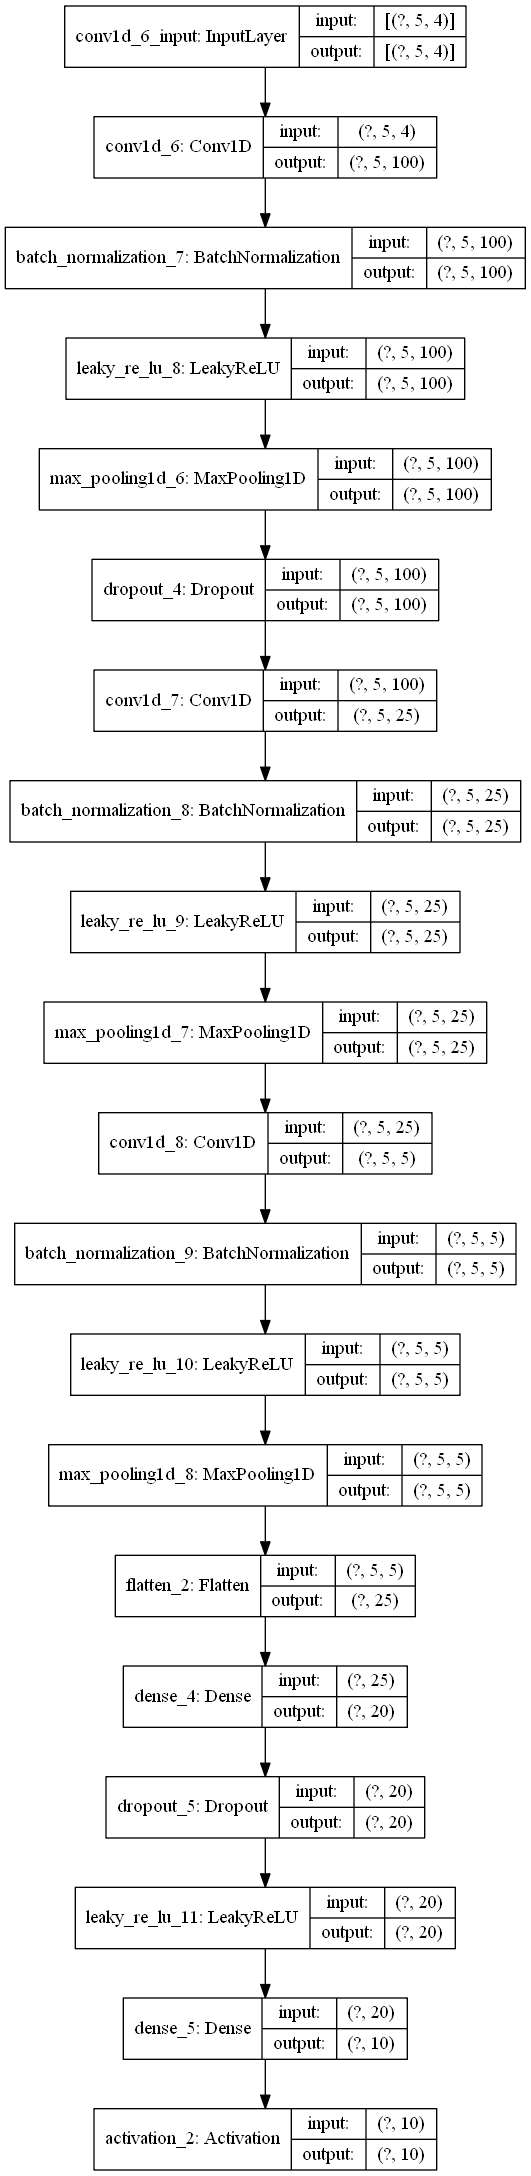

In [47]:
tf.keras.utils.plot_model(
    model, to_file='cnn.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [48]:
#train the model
model.fit(X_train, y_train, epochs = 100, 
          batch_size = 10, verbose=0, 
          validation_split=0.1, shuffle=False)

In [49]:
# Evaluate the model
model.evaluate(X_test, y_test, batch_size=5, verbose=0) 
# AS the output from the CNN model with softmax activator is the probability distribution, 
#the accuracy score will be skewed due to the fact that the y_test values # are in the form of [0, 1] or [1, 0] 
#while prediction output is in the form of [0.2899034, 0.7122004]. We will ignore the accuracy metric 
#here but will calculate it once we transform the output into [0, 1] format

[1.383099913597107, 0.03054448962211609]

In [50]:
#make predictions 
pred = model.predict(np.array(X_test))

In [51]:
#reshape y_test and y_pred
y_test = np.reshape(y_test,(len(y_test), forecast, 2))
y_pred = np.reshape(pred,(len(pred), forecast, 2))

In [52]:
y_pred[:1]

array([[[0.05434021, 0.9440879 ],
        [0.03022349, 0.9675528 ],
        [0.08097622, 0.92171484],
        [0.13329172, 0.8485976 ],
        [0.27000707, 0.7468939 ]]], dtype=float32)

In [53]:
for i in range(10):
    print([1-np.argmax(p) for p in y_pred[i]], [1-np.argmax(y) for y in y_test[i]])

[0, 0, 0, 0, 0] [1, 0, 0, 0, 0]
[0, 0, 0, 0, 1] [0, 0, 0, 0, 0]
[1, 1, 0, 0, 0] [0, 0, 0, 0, 0]
[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]
[1, 1, 1, 1, 1] [1, 0, 0, 0, 1]
[0, 0, 0, 0, 1] [0, 0, 0, 1, 0]
[0, 1, 0, 0, 0] [0, 0, 1, 0, 0]
[1, 1, 1, 1, 1] [0, 1, 0, 0, 0]
[1, 0, 0, 0, 1] [1, 0, 0, 0, 0]
[1, 0, 0, 0, 0] [0, 0, 0, 0, 0]


In [54]:
# evaluate model efficiency by plotting confusion matrix
days = ['Day_'+f'{j+1}' for j in range(forecast)]
results={days[i]:[] for i in range(len(days))}
actuals={days[i]:[] for i in range(len(days))}
for i in range(len(y_test)):
    for j in range(len(days)):
        results[days[j]].append(1- np.argmax([p for p in y_pred[i][j]]))
        #actuals[days[j]].append(y_test[i][j])
        actuals[days[j]].append(1- np.argmax([y for y in y_test[i][j]]))
results_df=pd.DataFrame(results)
actuals_df=pd.DataFrame(actuals)

In [55]:
#create classification report
for col in actuals_df.columns:
    c_report = classification_report(actuals_df[col], results_df[col])
    print(col, '----------------------\n', c_report, '\n--------------------------------------------------')

Day_1 ----------------------
               precision    recall  f1-score   support

           0       0.53      0.42      0.47       399
           1       0.47      0.58      0.52       354

    accuracy                           0.50       753
   macro avg       0.50      0.50      0.50       753
weighted avg       0.50      0.50      0.49       753
 
--------------------------------------------------
Day_2 ----------------------
               precision    recall  f1-score   support

           0       0.48      0.36      0.41       382
           1       0.47      0.59      0.52       371

    accuracy                           0.47       753
   macro avg       0.47      0.48      0.47       753
weighted avg       0.47      0.47      0.47       753
 
--------------------------------------------------
Day_3 ----------------------
               precision    recall  f1-score   support

           0       0.45      0.34      0.39       375
           1       0.48      0.60      0.53

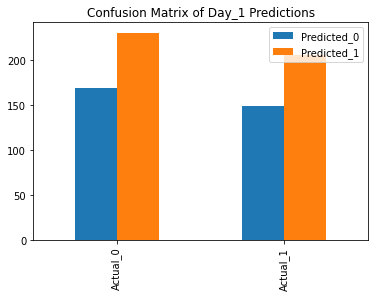

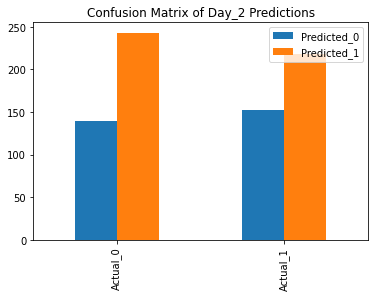

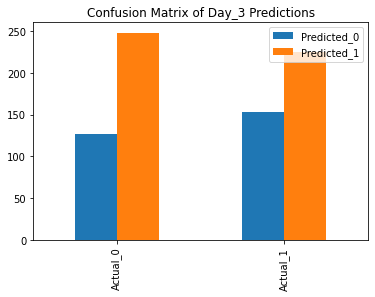

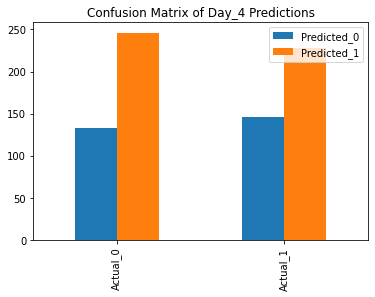

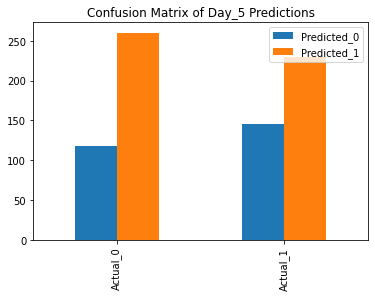

In [56]:
#plot confusion matrix
for col in actuals_df.columns:
    pd.DataFrame(confusion_matrix(actuals_df[col], results_df[col]),
    columns=['Predicted_0', 'Predicted_1'], index=['Actual_0', 'Actual_1']).plot(kind='bar', title='Confusion Matrix of '+ f'{col}' +' Predictions')